In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [92]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3) #26x26x32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3) #24x24x32
        self.bn2 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(2, 2) #12x12x32
        self.dr1 = nn.Dropout(0.1)
        
        self.conv3 = nn.Conv2d(32, 8, 1) #12x12x8
        self.bn3 = nn.BatchNorm2d(8)
        self.conv4 = nn.Conv2d(8, 32, 5) #8x8x32
        self.bn4 = nn.BatchNorm2d(32)
        self.pool2 = nn.MaxPool2d(2, 2) #4x4x32
        self.dr2 = nn.Dropout(0.1)
        
        self.conv5 = nn.Conv2d(32, 16, 1) #4x4x16
        self.bn5 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(256, 10)

    def forward(self, x):
        x = self.dr1(self.pool1(self.bn2(F.relu(self.conv2(self.bn1(F.relu(self.conv1(x))))))))
        x = self.dr2(self.pool2(self.bn4(F.relu(self.conv4(self.bn3(F.relu(self.conv3(x))))))))
        x = self.bn5(F.relu(self.conv5(x)))
        x = x.view(-1, 256)
        x = self.fc(x)
        return F.log_softmax(x)

In [93]:
#!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
       BatchNorm2d-2           [-1, 32, 26, 26]              64
            Conv2d-3           [-1, 32, 24, 24]           9,248
       BatchNorm2d-4           [-1, 32, 24, 24]              64
         MaxPool2d-5           [-1, 32, 12, 12]               0
           Dropout-6           [-1, 32, 12, 12]               0
            Conv2d-7            [-1, 8, 12, 12]             264
       BatchNorm2d-8            [-1, 8, 12, 12]              16
            Conv2d-9             [-1, 32, 8, 8]           6,432
      BatchNorm2d-10             [-1, 32, 8, 8]              64
        MaxPool2d-11             [-1, 32, 4, 4]               0
          Dropout-12             [-1, 32, 4, 4]               0
           Conv2d-13             [-1, 16, 4, 4]             528
      BatchNorm2d-14             [-1, 1

/var/folders/p9/jct14jsd3_5c7s62tsk5dtxc0000gn/T/ipykernel_25906/1732294689.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [94]:


torch.manual_seed(1)
batch_size = 32

kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
                        transforms.Resize((28, 28)),
                        transforms.RandomRotation((-15., 15.), fill=0),
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


In [102]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()


def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0
    
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        train_loss+=loss.item()
        loss.backward()
        optimizer.step()
        correct += GetCorrectPredCount(output, target)
        processed += len(data)
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')
    return 100. * correct / processed, train_loss


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset), test_loss

In [103]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [104]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)

for epoch in range(1, 20):
    train_acc_val, train_loss = train(model, device, train_loader, optimizer, epoch)
    test_acc_val, test_loss = test(model, device, test_loader)
    
    train_acc.append(train_acc_val) #Storing training loss for each epoch
    train_losses.append(train_loss)
    test_acc.append(test_acc_val) #Storing testing loss for each epoch
    test_losses.append(test_loss)
    #scheduler.step()

  0%|                                                  | 0/1875 [00:00<?, ?it/s]/var/folders/p9/jct14jsd3_5c7s62tsk5dtxc0000gn/T/ipykernel_25906/1732294689.py:28: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
loss=0.058363284915685654 batch_id=1874: 100%|█| 1875/1875 [01:05<00:00, 28.55it



Test set: Average loss: 0.0399, Accuracy: 9873/10000 (99%)



loss=0.15196651220321655 batch_id=1874: 100%|█| 1875/1875 [01:18<00:00, 23.86it/



Test set: Average loss: 0.0332, Accuracy: 9886/10000 (99%)



loss=0.007066930644214153 batch_id=1874: 100%|█| 1875/1875 [01:29<00:00, 20.85it



Test set: Average loss: 0.0276, Accuracy: 9910/10000 (99%)



loss=0.0531914122402668 batch_id=1874: 100%|█| 1875/1875 [01:35<00:00, 19.60it/s



Test set: Average loss: 0.0242, Accuracy: 9916/10000 (99%)



loss=0.0979321300983429 batch_id=1874: 100%|█| 1875/1875 [01:40<00:00, 18.64it/s



Test set: Average loss: 0.0220, Accuracy: 9919/10000 (99%)



loss=0.11258920282125473 batch_id=1874: 100%|█| 1875/1875 [01:41<00:00, 18.44it/



Test set: Average loss: 0.0205, Accuracy: 9936/10000 (99%)



loss=0.026145746931433678 batch_id=1874: 100%|█| 1875/1875 [01:42<00:00, 18.22it



Test set: Average loss: 0.0215, Accuracy: 9930/10000 (99%)



loss=0.004064794164150953 batch_id=1874: 100%|█| 1875/1875 [01:44<00:00, 18.02it



Test set: Average loss: 0.0182, Accuracy: 9948/10000 (99%)



loss=0.030447719618678093 batch_id=1874: 100%|█| 1875/1875 [01:42<00:00, 18.36it



Test set: Average loss: 0.0182, Accuracy: 9941/10000 (99%)



loss=0.010542205534875393 batch_id=1874: 100%|█| 1875/1875 [01:41<00:00, 18.52it



Test set: Average loss: 0.0171, Accuracy: 9938/10000 (99%)



loss=0.01242121122777462 batch_id=1874: 100%|█| 1875/1875 [01:39<00:00, 18.76it/



Test set: Average loss: 0.0183, Accuracy: 9934/10000 (99%)



loss=0.014316298998892307 batch_id=1874: 100%|█| 1875/1875 [01:42<00:00, 18.28it



Test set: Average loss: 0.0161, Accuracy: 9948/10000 (99%)



loss=0.0003232169256079942 batch_id=1874: 100%|█| 1875/1875 [01:39<00:00, 18.85i



Test set: Average loss: 0.0185, Accuracy: 9938/10000 (99%)



loss=0.003820115700364113 batch_id=1874: 100%|█| 1875/1875 [01:38<00:00, 19.12it



Test set: Average loss: 0.0167, Accuracy: 9943/10000 (99%)



loss=0.004072012845426798 batch_id=1874: 100%|█| 1875/1875 [01:37<00:00, 19.26it



Test set: Average loss: 0.0178, Accuracy: 9944/10000 (99%)



loss=0.001494994037784636 batch_id=1874: 100%|█| 1875/1875 [01:37<00:00, 19.25it



Test set: Average loss: 0.0175, Accuracy: 9943/10000 (99%)



loss=0.00405545998364687 batch_id=1874: 100%|█| 1875/1875 [01:38<00:00, 19.04it/



Test set: Average loss: 0.0188, Accuracy: 9942/10000 (99%)



loss=0.022497111931443214 batch_id=1874: 100%|█| 1875/1875 [01:37<00:00, 19.32it



Test set: Average loss: 0.0165, Accuracy: 9948/10000 (99%)



loss=0.05203035846352577 batch_id=1874: 100%|█| 1875/1875 [01:37<00:00, 19.14it/



Test set: Average loss: 0.0172, Accuracy: 9940/10000 (99%)



Text(0.5, 1.0, 'Test Accuracy')

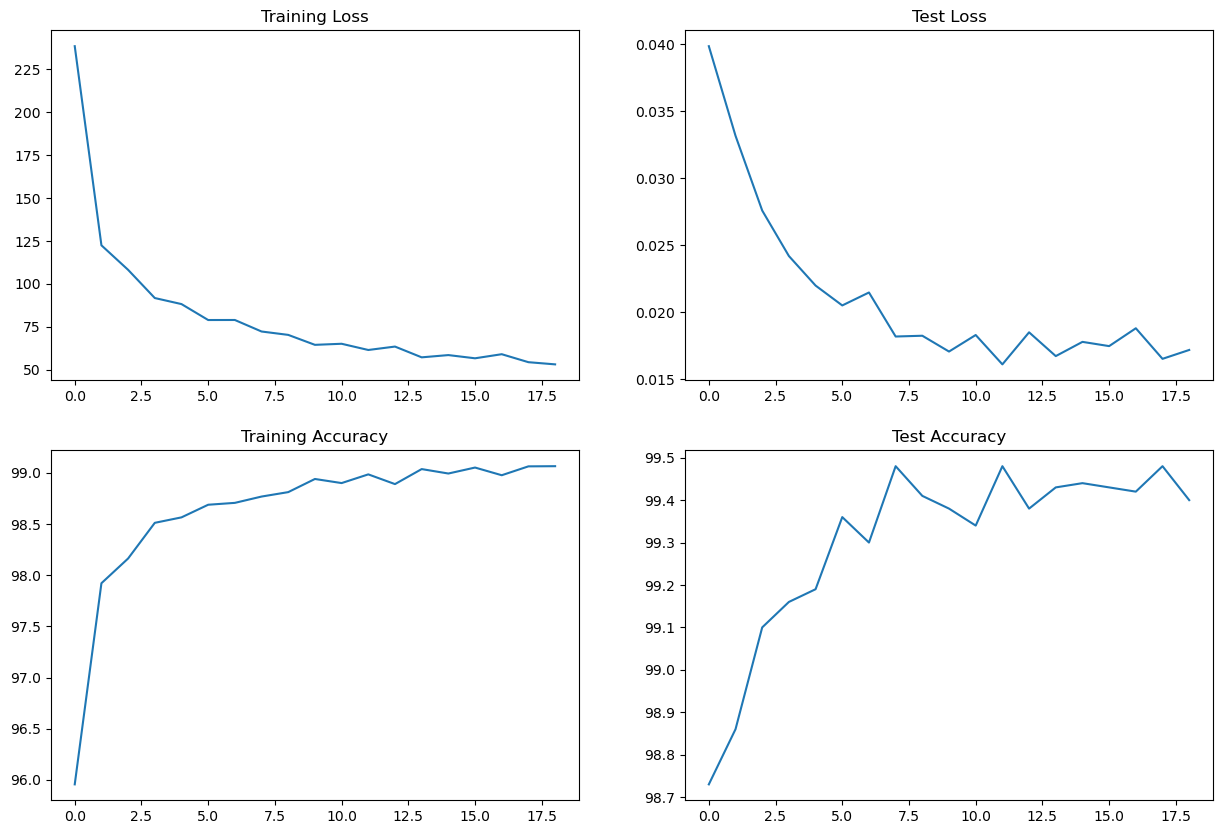

In [105]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")